In [3]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds, orthant_bounds
from MGTomo.gridop import RBox as R, PBox as P
from MGTomo import gridop

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.linalg import matrix_norm

import time

In [4]:
N = 511
max_levels = 4
maxIter = [1,4,16,50,64]
kernel_size = 11
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [torch.poisson(A[0](x_torch)*50)/50]
P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim

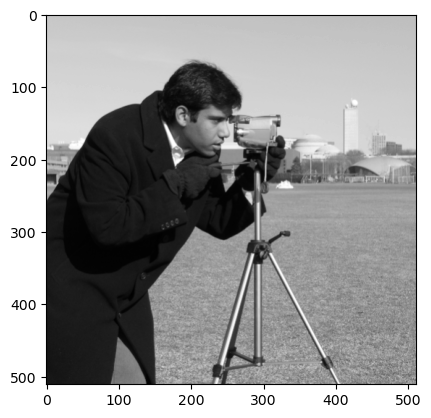

In [5]:
plt.imshow(x_orig, cmap='gray')

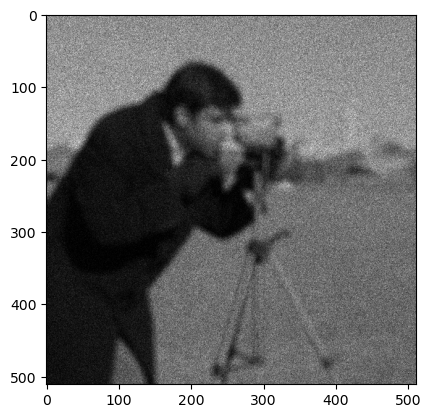

In [6]:
plt.imshow(b[0].detach(), cmap='gray')

In [7]:
def kl_distance_rev(x: torch.tensor, b: torch.tensor, A):
    ax = A(x)
    ax.requires_grad_(True)
    ba = mydiv(b,ax)
    
    erg = b * mylog(ba) - b + ax
    #fx = torch.sum(erg[b > 0.])
    fx = torch.sum( erg[ax > 0.]) + 0.5*torch.sum(b[ax == 0.]**2)
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [8]:
fh = lambda x: kl_distance_rev(x, b[0], A[0])
tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
P_inf = 1

In [9]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
w0.retain_grad()
#fh(w0).backward()
#w0.grad

fcts.mirror_descent_IS(fh, w0, tau[0], lh)

tensor([[0.5001, 0.5001, 0.5001,  ..., 0.5001, 0.5001, 0.5001],
        [0.5001, 0.5002, 0.5002,  ..., 0.5002, 0.5002, 0.5001],
        [0.5001, 0.5002, 0.5002,  ..., 0.5002, 0.5002, 0.5001],
        ...,
        [0.4998, 0.4997, 0.4997,  ..., 0.5001, 0.5001, 0.5000],
        [0.4998, 0.4997, 0.4997,  ..., 0.5001, 0.5001, 0.5000],
        [0.4999, 0.4998, 0.4998,  ..., 0.5000, 0.5000, 0.5000]])

In [10]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

w0.retain_grad()


for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val = fcts.mirror_descent_IS(fh, w0, tau[0], lh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 27683.25594717224 - Time: 0.221515 seconds
Iteration 1: 27655.37857132267 - Time: 0.218378 seconds
Iteration 2: 27627.540487563252 - Time: 0.218652 seconds
Iteration 3: 27599.741553243894 - Time: 0.231120 seconds
Iteration 4: 27571.981870367486 - Time: 0.218419 seconds
Iteration 5: 27544.261074029913 - Time: 0.218292 seconds
Iteration 6: 27516.57952475082 - Time: 0.218017 seconds
Iteration 7: 27488.936803386507 - Time: 0.218085 seconds
Iteration 8: 27461.333167467066 - Time: 0.218727 seconds
Iteration 9: 27433.768228587713 - Time: 0.218266 seconds
Iteration 10: 27406.24214133605 - Time: 0.219480 seconds
Iteration 11: 27378.754744113707 - Time: 0.218146 seconds
Iteration 12: 27351.305881525514 - Time: 0.231385 seconds
Iteration 13: 27323.89580108478 - Time: 0.221774 seconds
Iteration 14: 27296.52423378564 - Time: 0.218171 seconds
Iteration 15: 27269.191208372184 - Time: 0.221276 seconds
Iteration 16: 27241.89644800313 - Time: 0.218168 seconds
Iteration 17: 27214.64012226708

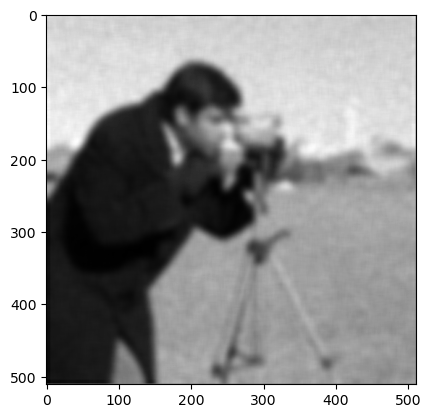

In [11]:
plt.imshow(w0.detach(), cmap='gray')

In [12]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if gcond:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            y_norm = matrix_norm(y)
            return (y_diff_norm >= eta * y_norm)
        return True
    else:
        return False

In [13]:
def MLO_orthant(fh, y, lh, last_pts: list, l=0, kappa = 0.49, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.clone().detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph=True)
    grad_fhy0 = y.grad.clone()
    y.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH = orthant_bounds(y, x, P_inf, lh, P_nonzero[l])
        
        for i in range(maxIter[l]):
            #x.retain_grad()
            val = fcts.mirror_descent_IS(psi, x, tau[l+1], lH)
            x = val.detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_orthant(psi, x, lH, last_pts, l+1)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval = fcts.mirror_descent_IS(fh, y, tau[l], lh)
        y = yval.detach().requires_grad_(True)
    return y, last_pts


In [14]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)

MLO_orthant(fh, z0, lh, last_pts)

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated


(tensor([[0.5003, 0.5006, 0.5007,  ..., 0.5006, 0.5005, 0.5003],
         [0.5006, 0.5011, 0.5014,  ..., 0.5013, 0.5011, 0.5005],
         [0.5007, 0.5014, 0.5017,  ..., 0.5016, 0.5013, 0.5006],
         ...,
         [0.4991, 0.4982, 0.4978,  ..., 0.5005, 0.5004, 0.5002],
         [0.4993, 0.4985, 0.4982,  ..., 0.5004, 0.5003, 0.5002],
         [0.4996, 0.4993, 0.4991,  ..., 0.5002, 0.5002, 0.5001]],
        requires_grad=True),
 [tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]),
  tensor([[0.5004, 0.5004, 0.5004,  ..., 0.5004, 0.5004, 0.5004],
          [0.5004, 0.5005, 0.5005,  ..., 0.5004, 0.5004, 0.5004],
          [0.5004, 0.

In [15]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_orthant(fh, z0, lh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 0: 27307.471845176486 - Time: 6.833150 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 1: 26912.7902869892 - Time: 6.452759 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 2: 26526.89772084476 - Time: 6.830589 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 3: 26149.561117562153 - Time: 6.883489 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 4: 25780.553461496933 - Time: 7.042639 seconds
0  : coarse correction activated
1  : 

KeyboardInterrupt: 

In [ ]:
z0.min()

tensor(0.4687, grad_fn=<MinBackward1>)

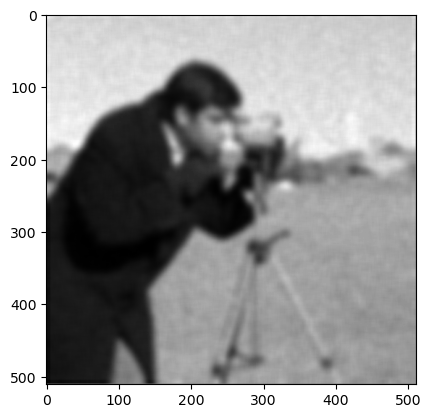

In [ ]:
plt.imshow(w0.detach(), cmap='gray')